<center><h1>1-ab: Introduction to Neural Networks</h1></center>

<center><h2><a href="https://rdfia.github.io/">Course link</a></h2></center>


In [1]:
import torch
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
%run "utils-data.py"

# Part 1 : Forward and backward passes "by hands"


In [39]:
def init_params(nx, nh, ny):
    """
    nx, nh, ny: integers
    nx : Taille de l'entrée
    nh : Taille de la sortie de la première couche cachée
    ny : Taille output de la dernière couche
    out params: dictionnary
    """
    params = {}

    # Initialize weights with a normal distribution (mean=0, std=0.3)
    params["Wh"] = torch.randn(nh, nx) * 0.3
    params["Wy"] = torch.randn(ny, nh) * 0.3

    # Initialize biases as zeros
    params["bh"] = torch.randn(nh)
    params["by"] = torch.randn(ny)

    return params

In [40]:
def forward(params, X):
    """
    params: dictionnary
    X: (n_batch, dimension)
    """
    bsize = X.size(0)
    nh = params["Wh"].size(0)
    ny = params["Wy"].size(0)
    outputs = {}

    # Forward pass

    outputs["X"] = X
    outputs["htilde"] = torch.mm(X, params["Wh"].t()) + params["bh"].repeat(bsize, 1)
    outputs["h"] = torch.tanh(outputs["htilde"])
    outputs["ytilde"] = torch.mm(outputs["h"], params["Wy"].t()) + params["by"].repeat(bsize, 1)
    outputs["yhat"] = torch.softmax(outputs["ytilde"], dim=1)

    return outputs["yhat"], outputs

In [41]:
def loss_accuracy(Yhat, Y):
    # Compute the loss
    L = -torch.mean(torch.sum(Y * torch.log(Yhat)))

    # Find the predicted class for each example
    _, indsYhat = torch.max(Yhat, 1)
    _, indsY = torch.max(Y, 1)

    # Compute the accuracy (rate of correct predictions)
    acc = 100 * torch.sum(indsYhat == indsY) / indsY.size(0)

    return L, acc

In [42]:
def backward(params, outputs, Y):
    bsize = Y.shape[0]
    grads = {}

    # Backward pass
    grads["yhat"] = outputs["yhat"] - Y
    grads["Wy"] = torch.mm(grads["yhat"].t(), outputs["h"])  # / bsize
    grads["by"] = torch.sum(grads["yhat"], dim=0).t()  # / bsize
    grads["htilde"] = torch.mm(grads["yhat"], params["Wy"]) * (1 - outputs["h"] ** 2)
    grads["Wh"] = torch.mm(grads["htilde"].t(), outputs["X"])  # / bsize
    grads["bh"] = torch.sum(grads["htilde"]).t()  # / bsize

    return grads

In [43]:
def sgd(params, grads, eta):
    params["Wh"] -= eta * grads["Wh"]
    params["Wy"] -= eta * grads["Wy"]
    params["bh"] -= eta * grads["bh"]
    params["by"] -= eta * grads["by"]
    return params

## Global learning procedure "by hands"


C:\Users\Hyperbeast\AppData\Local\Temp\ipykernel_32732\1953723500.py:1: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


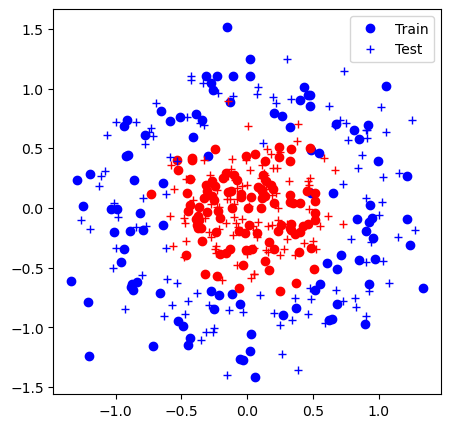

  0%|          | 0/150 [00:00<?, ?it/s]

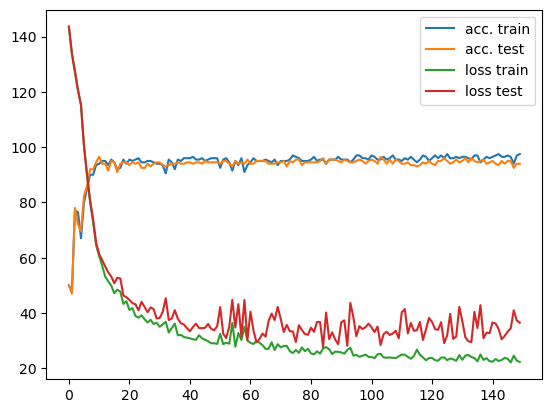

In [7]:
from tqdm.autonotebook import tqdm, trange

# init
data = CirclesData()
data.plot_data()
N = data.Xtrain.shape[0]
Nbatch = 10
nx = data.Xtrain.shape[1]
nh = 10
ny = data.Ytrain.shape[1]
eta = 0.03

params = init_params(nx, nh, ny)

curves = [[], [], [], []]

pbar = trange(150)

# epoch
for iteration in pbar:
    # permute
    perm = np.random.permutation(N)
    Xtrain = data.Xtrain[perm, :]
    Ytrain = data.Ytrain[perm, :]

    #####################
    ## Your code here  ##
    #####################
    # batches
    for j in range(N // Nbatch):
        indsBatch = range(j * Nbatch, (j + 1) * Nbatch)
        X = Xtrain[indsBatch, :]
        Y = Ytrain[indsBatch, :]

        # write the optimization algorithm on the batch (X,Y)
        # using the functions: forward, loss_accuracy, backward, sgd
        # Forward pass
        Yhat, outputs = forward(params, X)

        # Calculate loss and accuracy
        L, acc = loss_accuracy(Yhat, Y)

        # Backward pass
        grads = backward(params, outputs, Y)

        # Update parameters using SGD
        params = sgd(params, grads, eta)
    ####################
    ##      END        #
    ####################

    Yhat_train, _ = forward(params, data.Xtrain)
    Yhat_test, _ = forward(params, data.Xtest)
    Ltrain, acctrain = loss_accuracy(Yhat_train, data.Ytrain)
    Ltest, acctest = loss_accuracy(Yhat_test, data.Ytest)
    Ygrid, _ = forward(params, data.Xgrid)

    title = "Iter {}: Acc train {:.1f}% ({:.2f}), acc test {:.1f}% ({:.2f})".format(
        iteration + 1, acctrain, Ltrain, acctest, Ltest
    )
    pbar.set_description(title)
    # print(title)
    data.plot_data_with_grid(Ygrid, title)

    curves[0].append(acctrain)
    curves[1].append(acctest)
    curves[2].append(Ltrain)
    curves[3].append(Ltest)

fig = plt.figure()
plt.plot(curves[0], label="acc. train")
plt.plot(curves[1], label="acc. test")
plt.plot(curves[2], label="loss train")
plt.plot(curves[3], label="loss test")
plt.legend()
plt.savefig("manual_acc_loss.pdf", format="pdf", bbox_inches="tight")
plt.show()

data.save_gif("gif/part1.gif")

![](gif/part1.gif)


  0%|          | 0/500 [00:00<?, ?it/s]

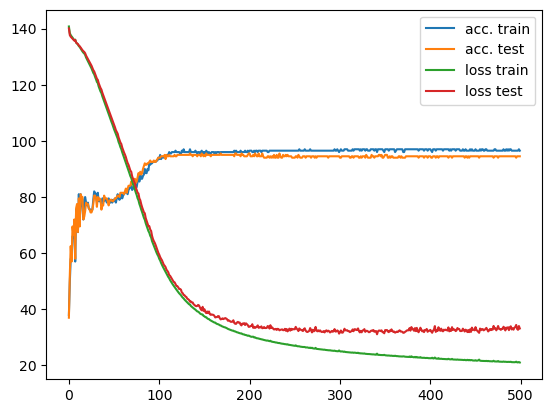

In [8]:
def backward_bis(params, outputs, Y):
    bsize = Y.shape[0]
    grads = {}

    # Backward pass
    grads["yhat"] = outputs["yhat"] - Y
    grads["Wy"] = torch.mm(grads["yhat"].t(), outputs["h"]) / bsize
    grads["by"] = torch.sum(grads["yhat"], dim=0).t() / bsize
    grads["htilde"] = torch.mm(grads["yhat"], params["Wy"]) * (1 - outputs["h"] ** 2)
    grads["Wh"] = torch.mm(grads["htilde"].t(), outputs["X"]) / bsize
    grads["bh"] = torch.sum(grads["htilde"]).t() / bsize

    return grads

from tqdm.autonotebook import tqdm, trange

# init
data = CirclesData()
N = data.Xtrain.shape[0]
Nbatch = 10
nx = data.Xtrain.shape[1]
nh = 10
ny = data.Ytrain.shape[1]
eta = 0.03

params = init_params(nx, nh, ny)

curves = [[], [], [], []]

pbar = trange(500)

# epoch
for iteration in pbar:
    # permute
    perm = np.random.permutation(N)
    Xtrain = data.Xtrain[perm, :]
    Ytrain = data.Ytrain[perm, :]

    #####################
    ## Your code here  ##
    #####################
    # batches
    for j in range(N // Nbatch):
        indsBatch = range(j * Nbatch, (j + 1) * Nbatch)
        X = Xtrain[indsBatch, :]
        Y = Ytrain[indsBatch, :]

        # write the optimization algorithm on the batch (X,Y)
        # using the functions: forward, loss_accuracy, backward, sgd
        # Forward pass
        Yhat, outputs = forward(params, X)

        # Calculate loss and accuracy
        L, acc = loss_accuracy(Yhat, Y)

        # Backward pass
        grads = backward_bis(params, outputs, Y)

        # Update parameters using SGD
        params = sgd(params, grads, eta)
    ####################
    ##      END        #
    ####################

    Yhat_train, _ = forward(params, data.Xtrain)
    Yhat_test, _ = forward(params, data.Xtest)
    Ltrain, acctrain = loss_accuracy(Yhat_train, data.Ytrain)
    Ltest, acctest = loss_accuracy(Yhat_test, data.Ytest)
    Ygrid, _ = forward(params, data.Xgrid)

    title = "Iter {}: Acc train {:.1f}% ({:.2f}), acc test {:.1f}% ({:.2f})".format(
        iteration + 1, acctrain, Ltrain, acctest, Ltest
    )
    pbar.set_description(title)
    # print(title)
    data.plot_data_with_grid(Ygrid, title)

    curves[0].append(acctrain)
    curves[1].append(acctest)
    curves[2].append(Ltrain)
    curves[3].append(Ltest)

fig = plt.figure()
plt.plot(curves[0], label="acc. train")
plt.plot(curves[1], label="acc. test")
plt.plot(curves[2], label="loss train")
plt.plot(curves[3], label="loss test")
plt.legend()
plt.savefig("manual_acc_loss_bis.pdf", format="pdf", bbox_inches="tight")
plt.show()

data.save_gif("gif/part1_bis.gif")

![](gif/part1_bis.gif)

## Influence of learning rate

LR: 0.001:   0%|          | 0/500 [00:00<?, ?it/s]

LR: 0.01:   0%|          | 0/500 [00:00<?, ?it/s]

LR: 0.05:   0%|          | 0/500 [00:00<?, ?it/s]

LR: 0.1:   0%|          | 0/500 [00:00<?, ?it/s]

LR: 0.5:   0%|          | 0/500 [00:00<?, ?it/s]

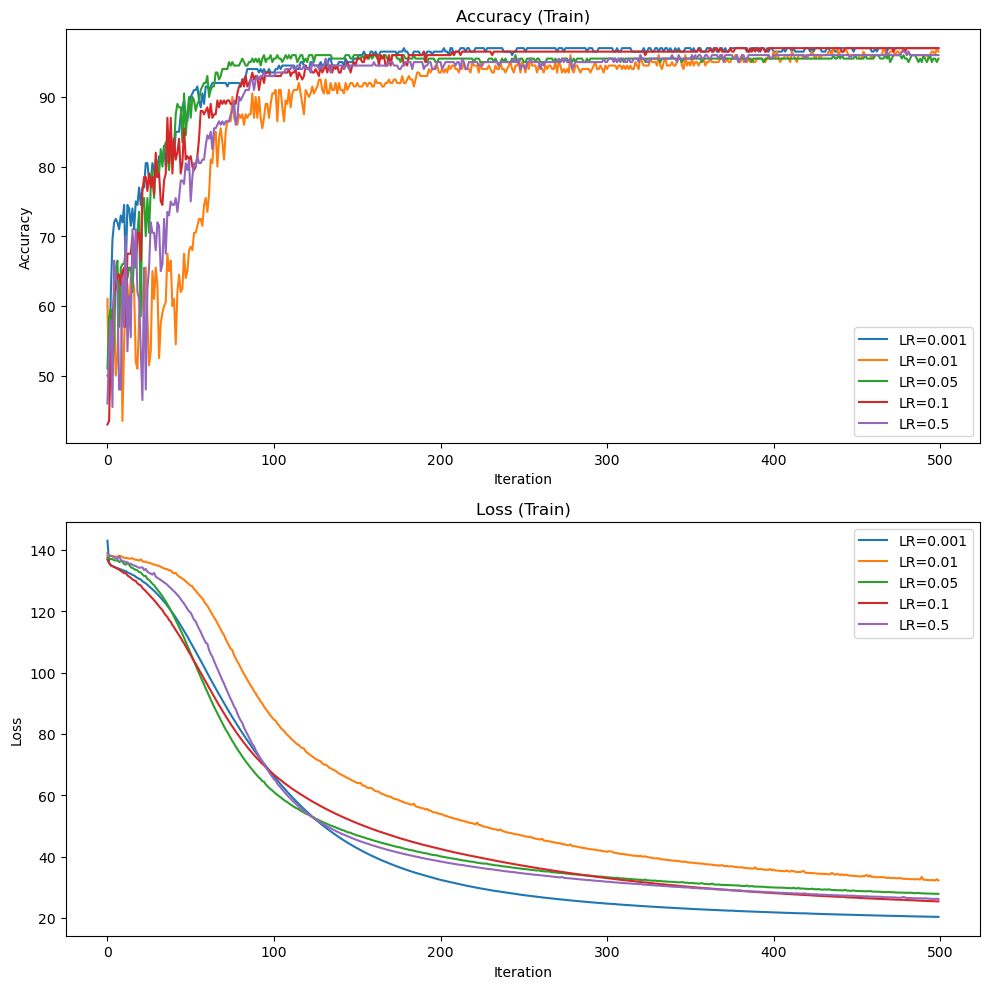

In [44]:
# Initialize data, parameters, and learning rates
data = CirclesData()
N = data.Xtrain.shape[0]
Nbatch = 10
nx = data.Xtrain.shape[1]
nh = 10
ny = data.Ytrain.shape[1]
learning_rates = [0.001, 0.01, 0.05, 0.1, 0.5]  # List of learning rates to test

curves = {lr: [[], [], [], []] for lr in learning_rates}

num_iterations = 500

for lr in learning_rates:
    params = init_params(nx, nh, ny)  # Initialize parameters for each batch size
    pbar = trange(num_iterations, desc=f"LR: {lr}")

    for iteration in pbar:
        perm = np.random.permutation(N)
        Xtrain = data.Xtrain[perm, :]
        Ytrain = data.Ytrain[perm, :]

        for j in range(N // Nbatch):
            indsBatch = range(j * Nbatch, (j + 1) * Nbatch)
            X = Xtrain[indsBatch, :]
            Y = Ytrain[indsBatch, :]

            # Forward pass
            Yhat, outputs = forward(params, X)

            # Calculate loss and accuracy
            L, acc = loss_accuracy(Yhat, Y)

            # Backward pass
            grads = backward_bis(params, outputs, Y)

            # Update parameters using SGD
            params = sgd(params, grads, eta)

        Yhat_train, _ = forward(params, data.Xtrain)
        Yhat_test, _ = forward(params, data.Xtest)
        Ltrain, acctrain = loss_accuracy(Yhat_train, data.Ytrain)
        Ltest, acctest = loss_accuracy(Yhat_test, data.Ytest)

        curves[lr][0].append(acctrain)
        curves[lr][1].append(acctest)
        curves[lr][2].append(Ltrain.detach().numpy())
        curves[lr][3].append(Ltest.detach().numpy())

        title = f"LR: {lr}, Iter {iteration + 1}: Acc train {acctrain:.1f}% ({Ltrain:.2f}), acc test {acctest:.1f}% ({Ltest:.2f})"
        pbar.set_description(title)

# Plot the results for each learning rate
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
for lr, curve in curves.items():
    axes[0].plot(curve[0], label=f"LR={lr}")
    axes[1].plot(curve[2], label=f"LR={lr}")

axes[0].set_title("Accuracy (Train)")
axes[0].set_xlabel("Iteration")
axes[0].set_ylabel("Accuracy")
axes[0].legend()

axes[1].set_title("Loss (Train)")
axes[1].set_xlabel("Iteration")
axes[1].set_ylabel("Loss")
axes[1].legend()

plt.tight_layout()
plt.savefig("manual_lr.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Influence of batch size

Batch Size: 10:   0%|          | 0/500 [00:00<?, ?it/s]

Batch Size: 20:   0%|          | 0/500 [00:00<?, ?it/s]

Batch Size: 50:   0%|          | 0/500 [00:00<?, ?it/s]

Batch Size: 100:   0%|          | 0/500 [00:00<?, ?it/s]

Batch Size: 200:   0%|          | 0/500 [00:00<?, ?it/s]

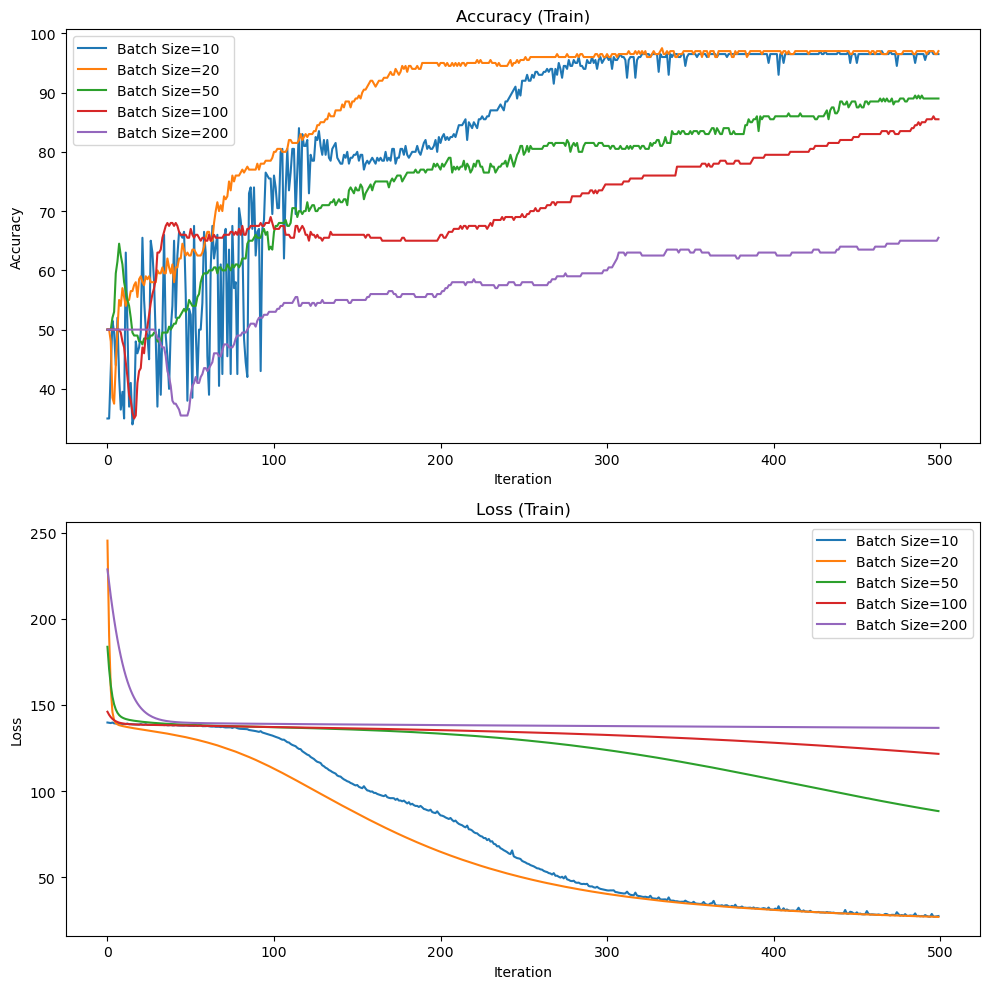

In [46]:
# Initialize data, parameters, and batch sizes
data = CirclesData()
N = data.Xtrain.shape[0]
nx = data.Xtrain.shape[1]
nh = 10
ny = data.Ytrain.shape[1]
batch_sizes = [10, 20, 50, 100, 200]  # List of batch sizes to test

curves = {batch_size: [[], [], [], []] for batch_size in batch_sizes}

num_iterations = 500

for Nbatch in batch_sizes:
    params = init_params(nx, nh, ny)
    pbar = trange(num_iterations, desc=f"Batch Size: {Nbatch}")

    for iteration in pbar:
        perm = np.random.permutation(N)
        Xtrain = data.Xtrain[perm, :]
        Ytrain = data.Ytrain[perm, :]

        for j in range(N // Nbatch):
            indsBatch = range(j * Nbatch, (j + 1) * Nbatch)
            X = Xtrain[indsBatch, :]
            Y = Ytrain[indsBatch, :]

            # Forward pass
            Yhat, outputs = forward(params, X)

            # Calculate loss and accuracy
            L, acc = loss_accuracy(Yhat, Y)

            # Backward pass
            grads = backward_bis(params, outputs, Y)

            # Update parameters using SGD
            params = sgd(params, grads, eta)

        Yhat_train, _ = forward(params, data.Xtrain)
        Yhat_test, _ = forward(params, data.Xtest)
        Ltrain, acctrain = loss_accuracy(Yhat_train, data.Ytrain)
        Ltest, acctest = loss_accuracy(Yhat_test, data.Ytest)

        curves[Nbatch][0].append(acctrain)
        curves[Nbatch][1].append(acctest)
        curves[Nbatch][2].append(Ltrain.detach().numpy())
        curves[Nbatch][3].append(Ltest.detach().numpy())

        title = f"Batch Size: {Nbatch}, Iter {iteration + 1}: Acc train {acctrain:.1f}% ({Ltrain:.2f}), acc test {acctest:.1f}% ({Ltest:.2f})"
        pbar.set_description(title)

# Plot the results for each batch size
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
for Nbatch, curve in curves.items():
    axes[0].plot(curve[0], label=f"Batch Size={Nbatch}")
    axes[1].plot(curve[2], label=f"Batch Size={Nbatch}")

axes[0].set_title("Accuracy (Train)")
axes[0].set_xlabel("Iteration")
axes[0].set_ylabel("Accuracy")
axes[0].legend()

axes[1].set_title("Loss (Train)")
axes[1].set_xlabel("Iteration")
axes[1].set_ylabel("Loss")
axes[1].legend()

plt.tight_layout()
plt.savefig("manual_batchsize.pdf", format="pdf", bbox_inches="tight")
plt.show()

# Part 2 : Simplification of the backward pass with `torch.autograd`


In [11]:
def init_params(nx, nh, ny):
    """
    nx, nh, ny: integers
    out params: dictionnary
    """
    params = {}

    # Initialize weights with a normal distribution
    params["Wh"] = torch.randn(nh, nx, requires_grad=True)
    params["Wy"] = torch.randn(ny, nh, requires_grad=True)

    # Initialize biases as zeros
    params["bh"] = torch.zeros(nh, requires_grad=True)
    params["by"] = torch.zeros(ny, requires_grad=True)

    return params

The function `forward` remains unchanged from previous part.

The function `backward` is no longer used because of "autograd".


In [12]:
def sgd(params, eta):
    # update the network weights
    # warning: use torch.no_grad()
    # and reset to zero the gradient accumulators

    with torch.no_grad():  # Use torch.no_grad() to avoid tracking operations in autograd
        params["Wy"] -= eta * params["Wy"].grad
        params["Wh"] -= eta * params["Wh"].grad
        params["by"] -= eta * params["by"].grad
        params["bh"] -= eta * params["bh"].grad

        # Reset the gradient accumulator to zero
        params["Wy"].grad.zero_()
        params["Wh"].grad.zero_()
        params["by"].grad.zero_()
        params["bh"].grad.zero_()

    return params

## Global learning procedure with autograd


  0%|          | 0/150 [00:00<?, ?it/s]

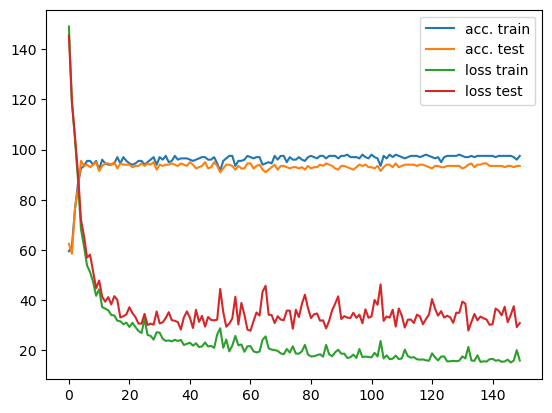

In [13]:
# init
data = CirclesData()
N = data.Xtrain.shape[0]
Nbatch = 10
nx = data.Xtrain.shape[1]
nh = 10
ny = data.Ytrain.shape[1]
eta = 0.03

params = init_params(nx, nh, ny)

curves = [[], [], [], []]

pbar = trange(150)

# epoch
for iteration in pbar:
    # permute
    perm = np.random.permutation(N)
    Xtrain = data.Xtrain[perm, :]
    Ytrain = data.Ytrain[perm, :]

    #####################
    ## Your code here  ##
    #####################
    # batches
    for j in range(N // Nbatch):
        indsBatch = range(j * Nbatch, (j + 1) * Nbatch)
        X = Xtrain[indsBatch, :]
        Y = Ytrain[indsBatch, :]

        # write the optimization algorithm on the batch (X,Y)
        # using the functions: forward, loss_accuracy, sgd
        # and the backward function with autograd
        # Forward pass
        Yhat, outputs = forward(params, X)

        # Calculate loss and accuracy
        L, acc = loss_accuracy(Yhat, Y)
        L.backward()

        # Update parameters using SGD
        params = sgd(params, eta)

    ####################
    ##      END        #
    ####################

    Yhat_train, _ = forward(params, data.Xtrain)
    Yhat_test, _ = forward(params, data.Xtest)
    Ltrain, acctrain = loss_accuracy(Yhat_train, data.Ytrain)
    Ltest, acctest = loss_accuracy(Yhat_test, data.Ytest)
    Ygrid, _ = forward(params, data.Xgrid)

    title = f"Iter {iteration + 1}: Acc train {acctrain:.1f}% ({Ltrain:.2f}), acc test {acctest:.1f}% ({Ltest:.2f})"
    pbar.set_description(title)
    # print(title)
    # detach() is used to remove the predictions from the computational graph in autograd
    data.plot_data_with_grid(Ygrid.detach(), title)

    curves[0].append(acctrain)
    curves[1].append(acctest)
    curves[2].append(Ltrain.detach().numpy())
    curves[3].append(Ltest.detach().numpy())

fig = plt.figure()
plt.plot(curves[0], label="acc. train")
plt.plot(curves[1], label="acc. test")
plt.plot(curves[2], label="loss train")
plt.plot(curves[3], label="loss test")
plt.legend()
plt.savefig("autograd_acc_loss.pdf", format="pdf", bbox_inches="tight")
plt.show()
data.save_gif("gif/part2.gif")

![](gif/part2.gif)


## Influence of learning rate

LR: 0.001:   0%|          | 0/150 [00:00<?, ?it/s]

LR: 0.01:   0%|          | 0/150 [00:00<?, ?it/s]

LR: 0.05:   0%|          | 0/150 [00:00<?, ?it/s]

LR: 0.1:   0%|          | 0/150 [00:00<?, ?it/s]

LR: 0.5:   0%|          | 0/150 [00:00<?, ?it/s]

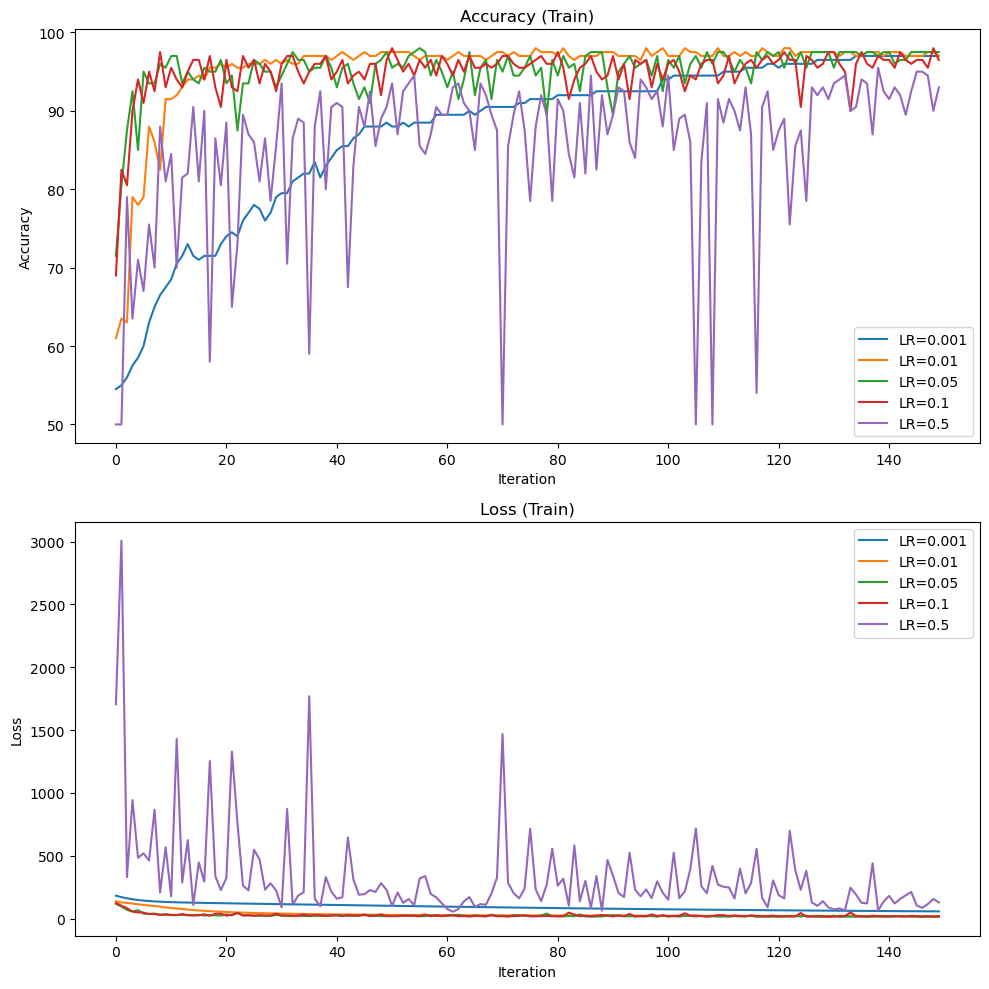

In [14]:
data = CirclesData()
N = data.Xtrain.shape[0]
Nbatch = 10
nx = data.Xtrain.shape[1]
nh = 10
ny = data.Ytrain.shape[1]
learning_rates = [0.001, 0.01, 0.05, 0.1, 0.5]  # List of learning rates to test

curves = {lr: [[], [], [], []] for lr in learning_rates}

num_iterations = 150

for lr in learning_rates:
    params = init_params(nx, nh, ny)
    pbar = trange(num_iterations, desc=f"LR: {lr}")

    for iteration in pbar:
        perm = np.random.permutation(N)
        Xtrain = data.Xtrain[perm, :]
        Ytrain = data.Ytrain[perm, :]

        for j in range(N // Nbatch):
            indsBatch = range(j * Nbatch, (j + 1) * Nbatch)
            X = Xtrain[indsBatch, :]
            Y = Ytrain[indsBatch, :]

            # Forward pass
            Yhat, outputs = forward(params, X)

            # Calculate loss and accuracy
            L, acc = loss_accuracy(Yhat, Y)
            L.backward()

            # Update parameters using SGD
            params = sgd(params, lr)

        Yhat_train, _ = forward(params, data.Xtrain)
        Yhat_test, _ = forward(params, data.Xtest)
        Ltrain, acctrain = loss_accuracy(Yhat_train, data.Ytrain)
        Ltest, acctest = loss_accuracy(Yhat_test, data.Ytest)

        curves[lr][0].append(acctrain)
        curves[lr][1].append(acctest)
        curves[lr][2].append(Ltrain.detach().numpy())
        curves[lr][3].append(Ltest.detach().numpy())

        title = f"LR: {lr}, Iter {iteration + 1}: Acc train {acctrain:.1f}% ({Ltrain:.2f}), acc test {acctest:.1f}% ({Ltest:.2f})"
        pbar.set_description(title)

# Plot the results for each learning rate
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
for lr, curve in curves.items():
    axes[0].plot(curve[0], label=f"LR={lr}")
    axes[1].plot(curve[2], label=f"LR={lr}")

axes[0].set_title("Accuracy (Train)")
axes[0].set_xlabel("Iteration")
axes[0].set_ylabel("Accuracy")
axes[0].legend()

axes[1].set_title("Loss (Train)")
axes[1].set_xlabel("Iteration")
axes[1].set_ylabel("Loss")
axes[1].legend()

plt.tight_layout()
plt.savefig("autograd_lr.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Influence of batch size

Batch Size: 10:   0%|          | 0/150 [00:00<?, ?it/s]

Batch Size: 20:   0%|          | 0/150 [00:00<?, ?it/s]

Batch Size: 50:   0%|          | 0/150 [00:00<?, ?it/s]

Batch Size: 100:   0%|          | 0/150 [00:00<?, ?it/s]

Batch Size: 200:   0%|          | 0/150 [00:00<?, ?it/s]

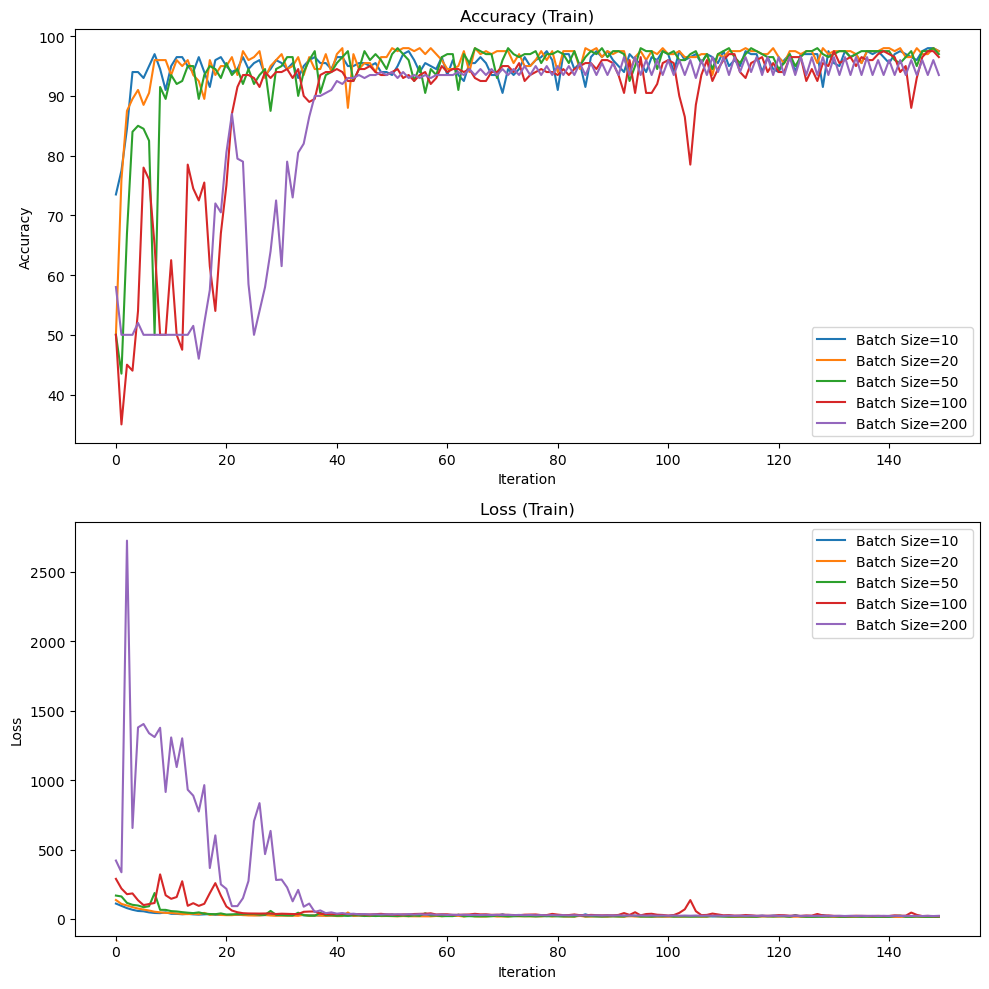

In [15]:
data = CirclesData()
N = data.Xtrain.shape[0]
nx = data.Xtrain.shape[1]
nh = 10
ny = data.Ytrain.shape[1]
batch_sizes = [10, 20, 50, 100, 200]  # List of batch sizes to test

curves = {batch_size: [[], [], [], []] for batch_size in batch_sizes}

num_iterations = 150

for Nbatch in batch_sizes:
    params = init_params(nx, nh, ny)
    pbar = trange(num_iterations, desc=f"Batch Size: {Nbatch}")

    for iteration in pbar:
        perm = np.random.permutation(N)
        Xtrain = data.Xtrain[perm, :]
        Ytrain = data.Ytrain[perm, :]

        for j in range(N // Nbatch):
            indsBatch = range(j * Nbatch, (j + 1) * Nbatch)
            X = Xtrain[indsBatch, :]
            Y = Ytrain[indsBatch, :]

            # Forward pass
            Yhat, outputs = forward(params, X)

            # Calculate loss and accuracy
            L, acc = loss_accuracy(Yhat, Y)
            L.backward()

            # Update parameters using SGD
            params = sgd(params, eta)

        Yhat_train, _ = forward(params, data.Xtrain)
        Yhat_test, _ = forward(params, data.Xtest)
        Ltrain, acctrain = loss_accuracy(Yhat_train, data.Ytrain)
        Ltest, acctest = loss_accuracy(Yhat_test, data.Ytest)

        curves[Nbatch][0].append(acctrain)
        curves[Nbatch][1].append(acctest)
        curves[Nbatch][2].append(Ltrain.detach().numpy())
        curves[Nbatch][3].append(Ltest.detach().numpy())

        title = f"Batch Size: {Nbatch}, Iter {iteration + 1}: Acc train {acctrain:.1f}% ({Ltrain:.2f}), acc test {acctest:.1f}% ({Ltest:.2f})"
        pbar.set_description(title)

# Plot the results for each batch size
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
for Nbatch, curve in curves.items():
    axes[0].plot(curve[0], label=f"Batch Size={Nbatch}")
    axes[1].plot(curve[2], label=f"Batch Size={Nbatch}")

axes[0].set_title("Accuracy (Train)")
axes[0].set_xlabel("Iteration")
axes[0].set_ylabel("Accuracy")
axes[0].legend()

axes[1].set_title("Loss (Train)")
axes[1].set_xlabel("Iteration")
axes[1].set_ylabel("Loss")
axes[1].legend()

plt.tight_layout()
plt.savefig("autograd_batchsize.pdf", format="pdf", bbox_inches="tight")
plt.show()

# Part 3 : Simplification of the forward pass with `torch.nn`


`init_params` and `forward` are replaced by the `init_model` function which defines the network architecture and the loss.


In [16]:
def init_model(nx, nh, ny):
    model = torch.nn.Sequential(
        torch.nn.Linear(nx, nh),
        torch.nn.Tanh(),
        torch.nn.Linear(nh, ny),
        # torch.nn.Softmax()
    )
    loss = torch.nn.CrossEntropyLoss()
    return model, loss

In [17]:
def loss_accuracy(loss, Yhat, Y):
    L = loss(Yhat, Y)
    acc = 100 * torch.mean((Yhat.argmax(1) == Y.argmax(1)).float())
    return L, acc

In [18]:
def sgd(model, eta):
    # update the network weights
    # warning: use torch.no_grad()
    # and reset to zero the gradient accumulators

    with torch.no_grad():
        for param in model.parameters():
            param -= eta * param.grad
            param.grad.zero_()
        # model.zero_grad()

    return model

## Global learning procedure with autograd and `torch.nn`


  0%|          | 0/250 [00:00<?, ?it/s]

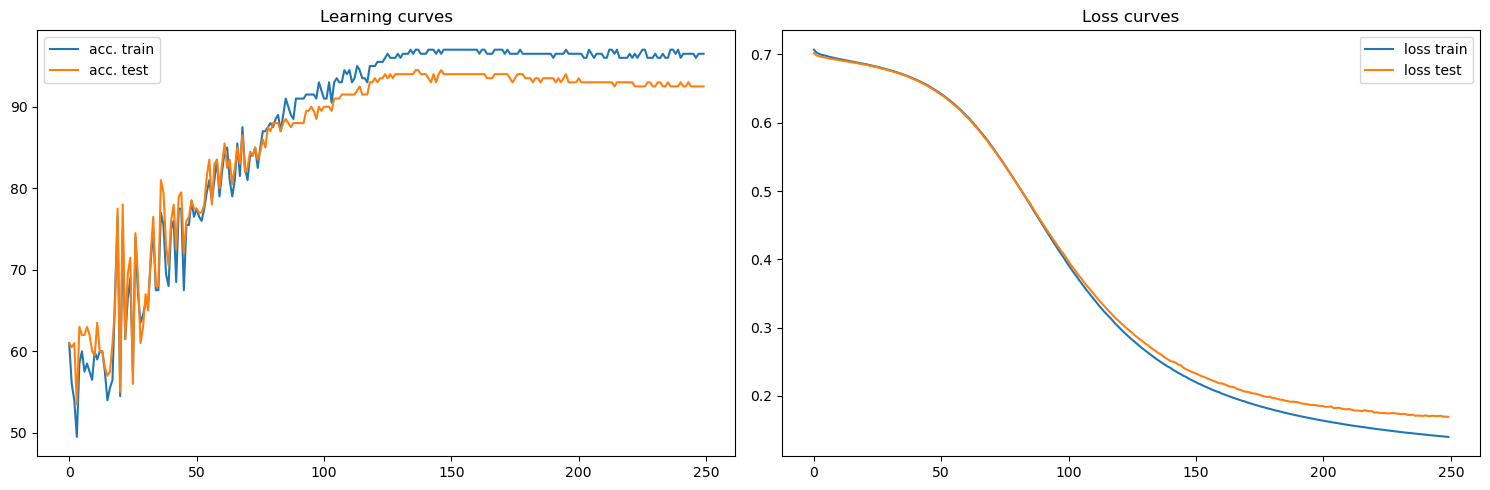

In [19]:
# init
data = CirclesData()
N = data.Xtrain.shape[0]
Nbatch = 10
nx = data.Xtrain.shape[1]
nh = 10
ny = data.Ytrain.shape[1]
eta = 0.03

model, loss = init_model(nx, nh, ny)

curves = [[], [], [], []]

pbar = trange(250)

# epoch
for iteration in pbar:
    # permute
    perm = np.random.permutation(N)
    Xtrain = data.Xtrain[perm, :]
    Ytrain = data.Ytrain[perm, :]

    #####################
    ## Your code here  ##
    #####################
    # batches
    for j in range(N // Nbatch):
        indsBatch = range(j * Nbatch, (j + 1) * Nbatch)
        X = Xtrain[indsBatch, :]
        Y = Ytrain[indsBatch, :]

        # write the optimization algorithm on the batch (X,Y)
        # using the functions: loss_accuracy, sgd
        # the forward with the predict method from the model
        # and the backward function with autograd
        # Forward pass
        Yhat = model(X)

        # Calculate loss and accuracy
        L, acc = loss_accuracy(loss, Yhat, Y)
        L.backward()

        # Update parameters using SGD
        model = sgd(model, eta=eta)

    ####################
    ##      END        #
    ####################

    Yhat_train = model(data.Xtrain)
    Yhat_test = model(data.Xtest)
    Ltrain, acctrain = loss_accuracy(loss, Yhat_train, data.Ytrain)
    Ltest, acctest = loss_accuracy(loss, Yhat_test, data.Ytest)
    Ygrid = model(data.Xgrid)

    title = "Iter {}: Acc train {:.1f}% ({:.2f}), acc test {:.1f}% ({:.2f})".format(
        iteration, acctrain, Ltrain, acctest, Ltest
    )
    pbar.set_description(title)
    data.plot_data_with_grid(torch.nn.Softmax(dim=1)(Ygrid.detach()), title)

    curves[0].append(acctrain)
    curves[1].append(acctest)
    curves[2].append(Ltrain.detach())
    curves[3].append(Ltest.detach())

fig = plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(curves[0], label="acc. train")
plt.plot(curves[1], label="acc. test")
plt.title("Learning curves")
plt.legend()
plt.subplot(122)
plt.plot(curves[2], label="loss train")
plt.plot(curves[3], label="loss test")
plt.title("Loss curves")
plt.legend()
plt.tight_layout()
plt.savefig("torchnn_acc_loss.pdf", format="pdf", bbox_inches="tight")
plt.show()
data.save_gif("gif/part3.gif")

![](gif/part3.gif)


## Influence of learning rate

LR: 0.001:   0%|          | 0/250 [00:00<?, ?it/s]

LR: 0.01:   0%|          | 0/250 [00:00<?, ?it/s]

LR: 0.05:   0%|          | 0/250 [00:00<?, ?it/s]

LR: 0.1:   0%|          | 0/250 [00:00<?, ?it/s]

LR: 0.5:   0%|          | 0/250 [00:00<?, ?it/s]

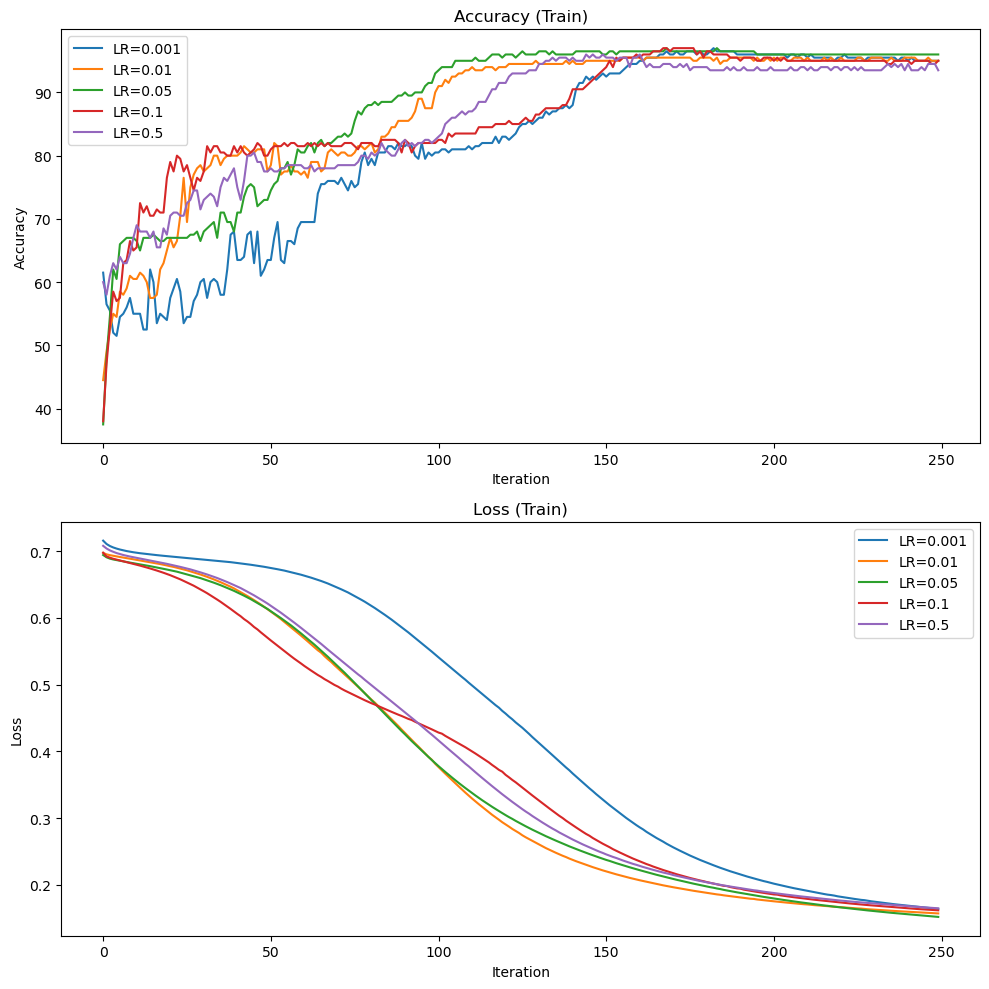

In [20]:
data = CirclesData()
N = data.Xtrain.shape[0]
Nbatch = 10
nx = data.Xtrain.shape[1]
nh = 10
ny = data.Ytrain.shape[1]
learning_rates = [0.001, 0.01, 0.05, 0.1, 0.5]  # List of learning rates to test

curves = {lr: [[], [], [], []] for lr in learning_rates}

num_iterations = 250

for lr in learning_rates:
    model, loss = init_model(nx, nh, ny)
    pbar = trange(num_iterations, desc=f"LR: {lr}")

    for iteration in pbar:
        perm = np.random.permutation(N)
        Xtrain = data.Xtrain[perm, :]
        Ytrain = data.Ytrain[perm, :]

        for j in range(N // Nbatch):
            indsBatch = range(j * Nbatch, (j + 1) * Nbatch)
            X = Xtrain[indsBatch, :]
            Y = Ytrain[indsBatch, :]

            # Forward pass
            Yhat = model(X)

            # Calculate loss and accuracy
            L, acc = loss_accuracy(loss, Yhat, Y)
            L.backward()

            # Update parameters using SGD
            model = sgd(model, eta=eta)

        Yhat_train = model(data.Xtrain)
        Yhat_test = model(data.Xtest)
        Ltrain, acctrain = loss_accuracy(loss, Yhat_train, data.Ytrain)
        Ltest, acctest = loss_accuracy(loss, Yhat_test, data.Ytest)

        curves[lr][0].append(acctrain)
        curves[lr][1].append(acctest)
        curves[lr][2].append(Ltrain.detach().numpy())
        curves[lr][3].append(Ltest.detach().numpy())

        title = f"LR: {lr}, Iter {iteration + 1}: Acc train {acctrain:.1f}% ({Ltrain:.2f}), acc test {acctest:.1f}% ({Ltest:.2f})"
        pbar.set_description(title)

# Plot the results for each learning rate
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
for lr, curve in curves.items():
    axes[0].plot(curve[0], label=f"LR={lr}")
    axes[1].plot(curve[2], label=f"LR={lr}")

axes[0].set_title("Accuracy (Train)")
axes[0].set_xlabel("Iteration")
axes[0].set_ylabel("Accuracy")
axes[0].legend()

axes[1].set_title("Loss (Train)")
axes[1].set_xlabel("Iteration")
axes[1].set_ylabel("Loss")
axes[1].legend()

plt.tight_layout()
plt.savefig("torchnn_lr.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Influence of batch size

Batch Size: 10:   0%|          | 0/250 [00:00<?, ?it/s]

Batch Size: 20:   0%|          | 0/250 [00:00<?, ?it/s]

Batch Size: 50:   0%|          | 0/250 [00:00<?, ?it/s]

Batch Size: 100:   0%|          | 0/250 [00:00<?, ?it/s]

Batch Size: 200:   0%|          | 0/250 [00:00<?, ?it/s]

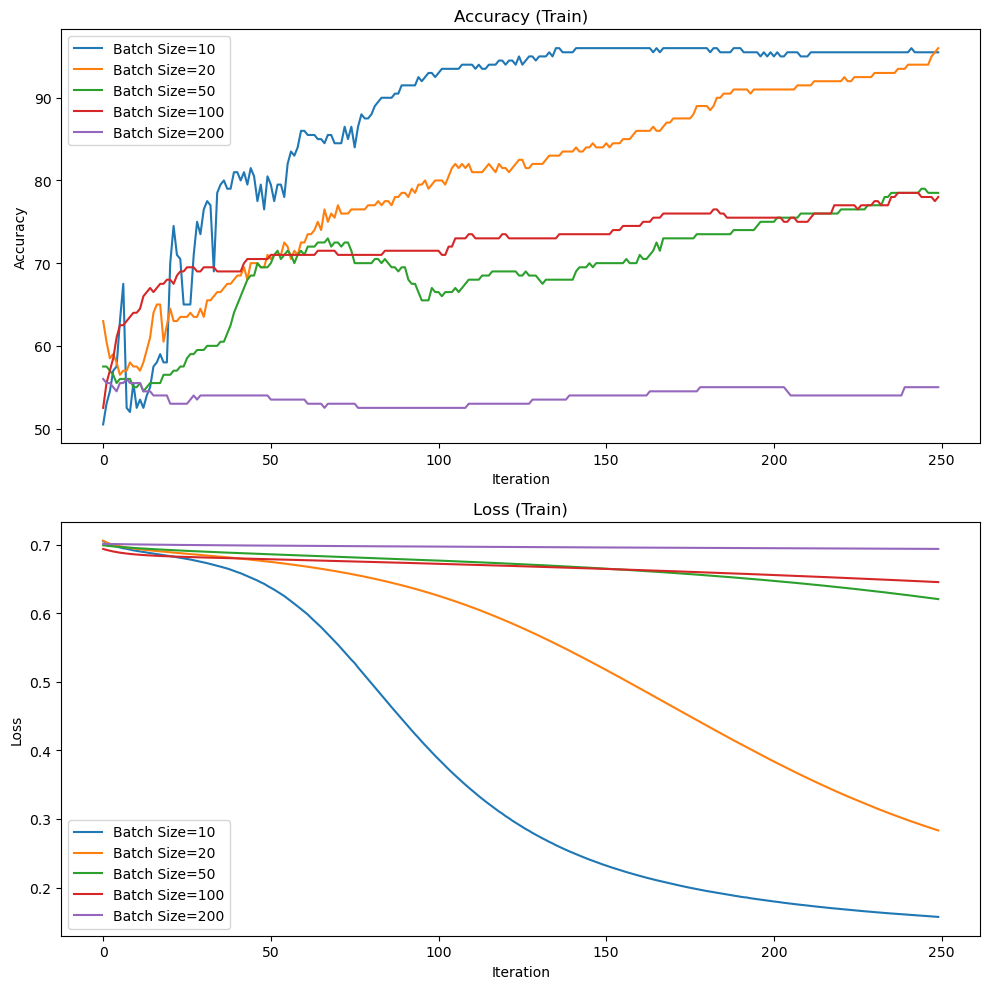

In [21]:
data = CirclesData()
N = data.Xtrain.shape[0]
nx = data.Xtrain.shape[1]
nh = 10
ny = data.Ytrain.shape[1]
batch_sizes = [10, 20, 50, 100, 200]  # List of batch sizes to test

curves = {batch_size: [[], [], [], []] for batch_size in batch_sizes}

num_iterations = 250

for Nbatch in batch_sizes:
    model, loss = init_model(nx, nh, ny)
    pbar = trange(num_iterations, desc=f"Batch Size: {Nbatch}")

    for iteration in pbar:
        perm = np.random.permutation(N)
        Xtrain = data.Xtrain[perm, :]
        Ytrain = data.Ytrain[perm, :]

        for j in range(N // Nbatch):
            indsBatch = range(j * Nbatch, (j + 1) * Nbatch)
            X = Xtrain[indsBatch, :]
            Y = Ytrain[indsBatch, :]

            # Forward pass
            Yhat = model(X)

            # Calculate loss and accuracy
            L, acc = loss_accuracy(loss, Yhat, Y)
            L.backward()

            # Update parameters using SGD
            model = sgd(model, eta=eta)

        Yhat_train = model(data.Xtrain)
        Yhat_test = model(data.Xtest)
        Ltrain, acctrain = loss_accuracy(loss, Yhat_train, data.Ytrain)
        Ltest, acctest = loss_accuracy(loss, Yhat_test, data.Ytest)

        curves[Nbatch][0].append(acctrain)
        curves[Nbatch][1].append(acctest)
        curves[Nbatch][2].append(Ltrain.detach().numpy())
        curves[Nbatch][3].append(Ltest.detach().numpy())

        title = f"Batch Size: {Nbatch}, Iter {iteration + 1}: Acc train {acctrain:.1f}% ({Ltrain:.2f}), acc test {acctest:.1f}% ({Ltest:.2f})"
        pbar.set_description(title)

# Plot the results for each batch size
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
for Nbatch, curve in curves.items():
    axes[0].plot(curve[0], label=f"Batch Size={Nbatch}")
    axes[1].plot(curve[2], label=f"Batch Size={Nbatch}")

axes[0].set_title("Accuracy (Train)")
axes[0].set_xlabel("Iteration")
axes[0].set_ylabel("Accuracy")
axes[0].legend()

axes[1].set_title("Loss (Train)")
axes[1].set_xlabel("Iteration")
axes[1].set_ylabel("Loss")
axes[1].legend()

plt.tight_layout()
plt.savefig("torchnn_batch_size.pdf", format="pdf", bbox_inches="tight")
plt.show()

# Part 4 : Simplification of the SGD with `torch.optim`


In [22]:
def init_model(nx, nh, ny, eta):
    model = torch.nn.Sequential(
        torch.nn.Linear(nx, nh),
        torch.nn.Tanh(),
        torch.nn.Linear(nh, ny),
        torch.nn.Softmax(),
    )
    loss = torch.nn.CrossEntropyLoss()
    optim = torch.optim.SGD(model.parameters(), lr=eta)
    return model, loss, optim

The `sgd` function is replaced by calling the `optim.zero_grad()` before the backward and `optim.step()` after.


## Algorithme global d'apprentissage (avec autograd, les couches `torch.nn` et `torch.optim`)


  0%|          | 0/500 [00:00<?, ?it/s]

c:\Users\Hyperbeast\anaconda3\lib\site-packages\torch\nn\modules\container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


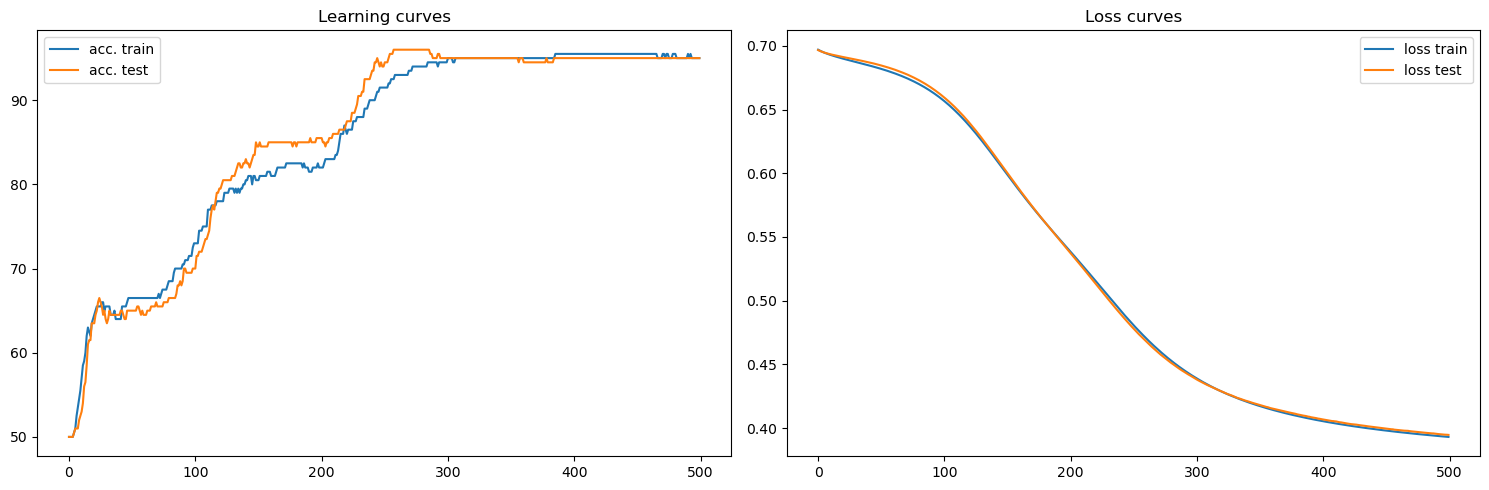

In [23]:
# init
data = CirclesData()
N = data.Xtrain.shape[0]
Nbatch = 10
nx = data.Xtrain.shape[1]
nh = 10
ny = data.Ytrain.shape[1]
eta = 0.03

model, loss, optim = init_model(nx, nh, ny, eta)

curves = [[], [], [], []]

pbar = trange(500)

# epoch
for iteration in pbar:
    # permute
    perm = np.random.permutation(N)
    Xtrain = data.Xtrain[perm, :]
    Ytrain = data.Ytrain[perm, :]

    #####################
    ## Your code  here ##
    #####################
    # batches
    for j in range(N // Nbatch):
        indsBatch = range(j * Nbatch, (j + 1) * Nbatch)
        X = Xtrain[indsBatch, :]
        Y = Ytrain[indsBatch, :]

        # write the optimization algorithm on the batch (X,Y)
        # using the functions: loss_accuracy
        # the forward with the predict method from the model
        # the backward function with autograd
        # and then an obackwardptimization step
        optim.zero_grad()

        Yhat = model(X)
        L, acc = loss_accuracy(loss, Yhat, Y)
        L.backward()

        optim.step()

    ####################
    ##      FIN        #
    ####################

    Yhat_train = model(data.Xtrain)
    Yhat_test = model(data.Xtest)
    Ltrain, acctrain = loss_accuracy(loss, Yhat_train, data.Ytrain)
    Ltest, acctest = loss_accuracy(loss, Yhat_test, data.Ytest)
    Ygrid = model(data.Xgrid)

    title = "Iter {}: Acc train {:.1f}% ({:.2f}), acc test {:.1f}% ({:.2f})".format(
        iteration, acctrain, Ltrain, acctest, Ltest
    )
    pbar.set_description(title)
    # print(title)
    data.plot_data_with_grid(torch.nn.Softmax(dim=1)(Ygrid.detach()), title)

    curves[0].append(acctrain)
    curves[1].append(acctest)
    curves[2].append(Ltrain.detach())
    curves[3].append(Ltest.detach())

fig = plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(curves[0], label="acc. train")
plt.plot(curves[1], label="acc. test")
plt.title("Learning curves")
plt.legend()
plt.subplot(122)
plt.plot(curves[2], label="loss train")
plt.plot(curves[3], label="loss test")
plt.title("Loss curves")
plt.legend()
plt.tight_layout()
plt.savefig("torchoptim_acc_loss.pdf", format="pdf", bbox_inches="tight")
plt.show()
data.save_gif("gif/part4.gif")

![](gif/part4.gif)


## Influence of learning rate

LR: 0.001:   0%|          | 0/500 [00:00<?, ?it/s]

c:\Users\Hyperbeast\anaconda3\lib\site-packages\torch\nn\modules\container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


LR: 0.01:   0%|          | 0/500 [00:00<?, ?it/s]

LR: 0.05:   0%|          | 0/500 [00:00<?, ?it/s]

LR: 0.1:   0%|          | 0/500 [00:00<?, ?it/s]

LR: 0.5:   0%|          | 0/500 [00:00<?, ?it/s]

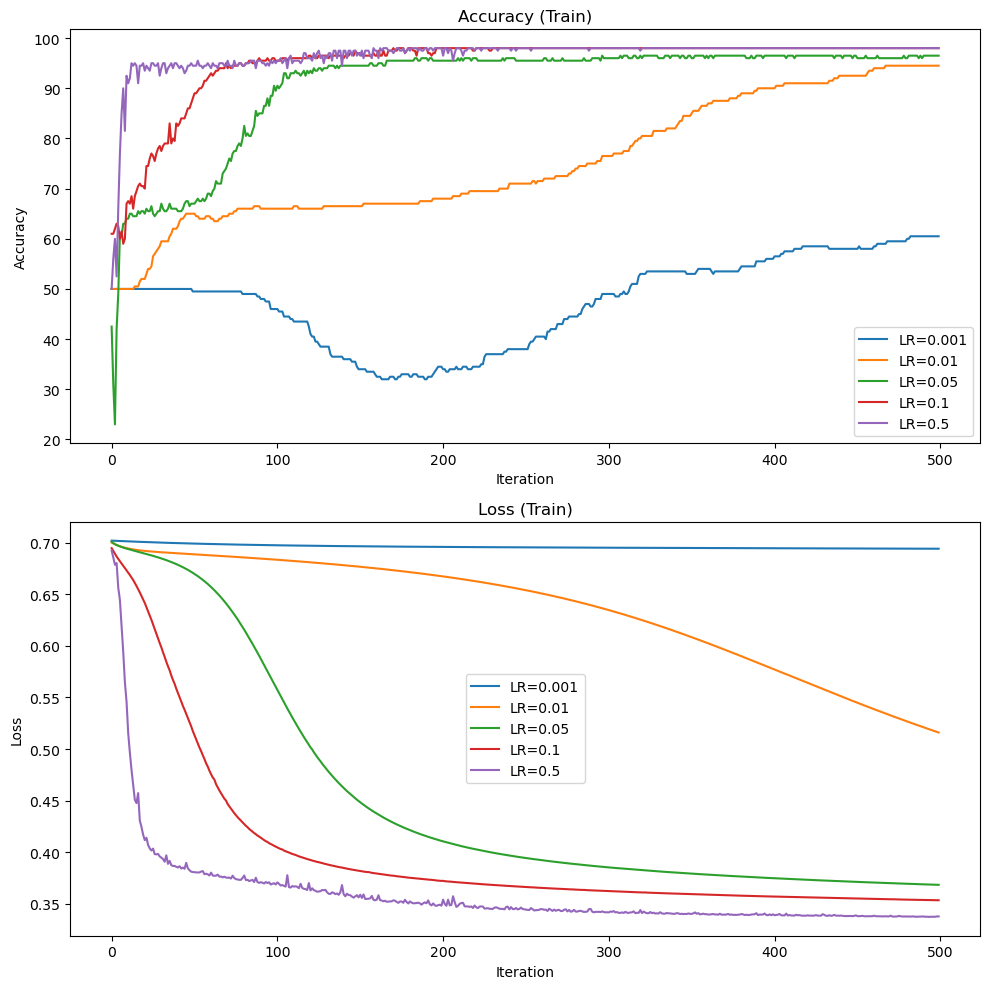

In [24]:
data = CirclesData()
N = data.Xtrain.shape[0]
Nbatch = 10
nx = data.Xtrain.shape[1]
nh = 10
ny = data.Ytrain.shape[1]
learning_rates = [0.001, 0.01, 0.05, 0.1, 0.5]  # List of learning rates to test

curves = {lr: [[], [], [], []] for lr in learning_rates}

num_iterations = 500

for lr in learning_rates:
    model, loss, optim = init_model(nx, nh, ny, lr)
    pbar = trange(num_iterations, desc=f"LR: {lr}")

    for iteration in pbar:
        perm = np.random.permutation(N)
        Xtrain = data.Xtrain[perm, :]
        Ytrain = data.Ytrain[perm, :]

        for j in range(N // Nbatch):
            indsBatch = range(j * Nbatch, (j + 1) * Nbatch)
            X = Xtrain[indsBatch, :]
            Y = Ytrain[indsBatch, :]

            optim.zero_grad()

            Yhat = model(X)
            L, acc = loss_accuracy(loss, Yhat, Y)
            L.backward()

            optim.step()

        Yhat_train = model(data.Xtrain)
        Yhat_test = model(data.Xtest)
        Ltrain, acctrain = loss_accuracy(loss, Yhat_train, data.Ytrain)
        Ltest, acctest = loss_accuracy(loss, Yhat_test, data.Ytest)

        curves[lr][0].append(acctrain)
        curves[lr][1].append(acctest)
        curves[lr][2].append(Ltrain.detach().numpy())
        curves[lr][3].append(Ltest.detach().numpy())

        title = f"LR: {lr}, Iter {iteration + 1}: Acc train {acctrain:.1f}% ({Ltrain:.2f}), acc test {acctest:.1f}% ({Ltest:.2f})"
        pbar.set_description(title)

# Plot the results for each learning rate
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
for lr, curve in curves.items():
    axes[0].plot(curve[0], label=f"LR={lr}")
    axes[1].plot(curve[2], label=f"LR={lr}")

axes[0].set_title("Accuracy (Train)")
axes[0].set_xlabel("Iteration")
axes[0].set_ylabel("Accuracy")
axes[0].legend()

axes[1].set_title("Loss (Train)")
axes[1].set_xlabel("Iteration")
axes[1].set_ylabel("Loss")
axes[1].legend()

plt.tight_layout()
plt.savefig("torchoptim_lr.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Influence of batch size

Batch Size: 10:   0%|          | 0/500 [00:00<?, ?it/s]

c:\Users\Hyperbeast\anaconda3\lib\site-packages\torch\nn\modules\container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Batch Size: 20:   0%|          | 0/500 [00:00<?, ?it/s]

Batch Size: 50:   0%|          | 0/500 [00:00<?, ?it/s]

Batch Size: 100:   0%|          | 0/500 [00:00<?, ?it/s]

Batch Size: 200:   0%|          | 0/500 [00:00<?, ?it/s]

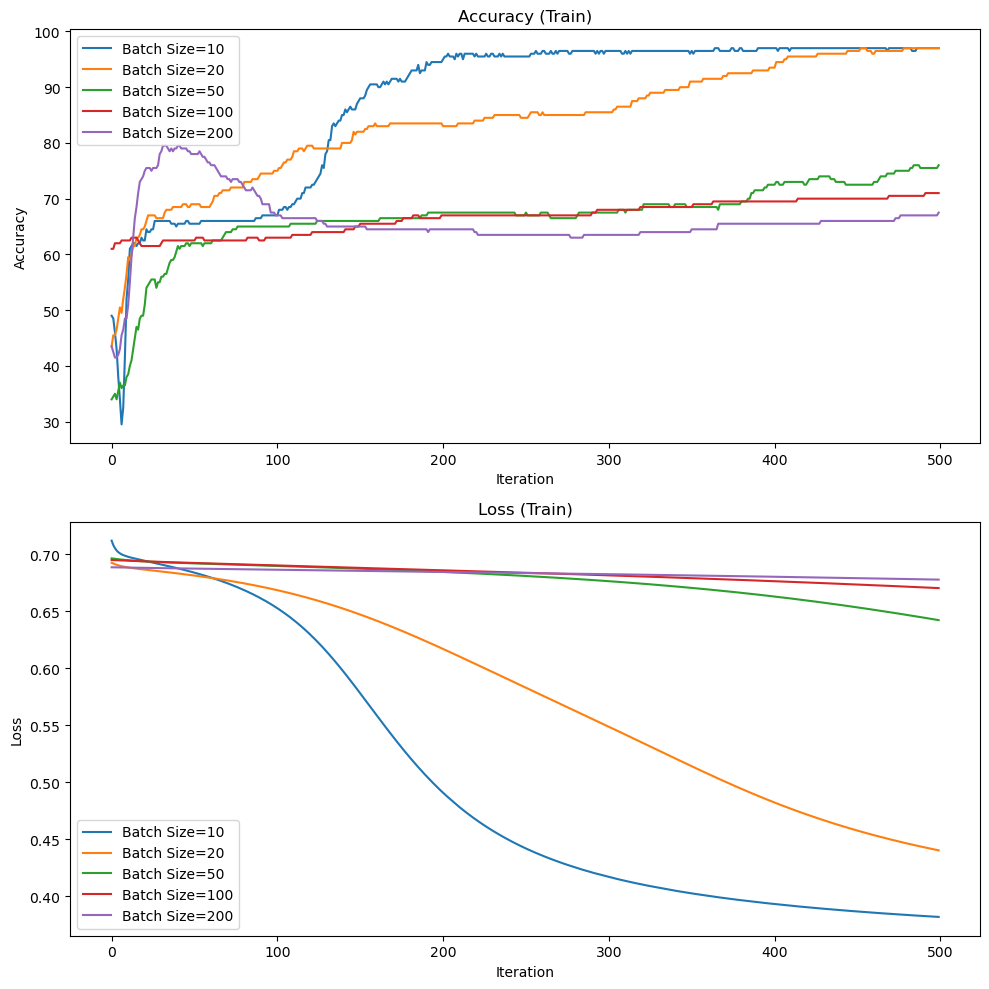

In [25]:
data = CirclesData()
N = data.Xtrain.shape[0]
nx = data.Xtrain.shape[1]
nh = 10
ny = data.Ytrain.shape[1]
batch_sizes = [10, 20, 50, 100, 200]  # List of batch sizes to test

curves = {batch_size: [[], [], [], []] for batch_size in batch_sizes}

num_iterations = 500

for Nbatch in batch_sizes:
    model, loss, optim = init_model(nx, nh, ny, 0.03)
    pbar = trange(num_iterations, desc=f"Batch Size: {Nbatch}")

    for iteration in pbar:
        perm = np.random.permutation(N)
        Xtrain = data.Xtrain[perm, :]
        Ytrain = data.Ytrain[perm, :]

        for j in range(N // Nbatch):
            indsBatch = range(j * Nbatch, (j + 1) * Nbatch)
            X = Xtrain[indsBatch, :]
            Y = Ytrain[indsBatch, :]

            optim.zero_grad()

            Yhat = model(X)
            L, acc = loss_accuracy(loss, Yhat, Y)
            L.backward()

            optim.step()

        Yhat_train = model(data.Xtrain)
        Yhat_test = model(data.Xtest)
        Ltrain, acctrain = loss_accuracy(loss, Yhat_train, data.Ytrain)
        Ltest, acctest = loss_accuracy(loss, Yhat_test, data.Ytest)

        curves[Nbatch][0].append(acctrain)
        curves[Nbatch][1].append(acctest)
        curves[Nbatch][2].append(Ltrain.detach().numpy())
        curves[Nbatch][3].append(Ltest.detach().numpy())

        title = f"Batch Size: {Nbatch}, Iter {iteration + 1}: Acc train {acctrain:.1f}% ({Ltrain:.2f}), acc test {acctest:.1f}% ({Ltest:.2f})"
        pbar.set_description(title)

# Plot the results for each batch size
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
for Nbatch, curve in curves.items():
    axes[0].plot(curve[0], label=f"Batch Size={Nbatch}")
    axes[1].plot(curve[2], label=f"Batch Size={Nbatch}")

axes[0].set_title("Accuracy (Train)")
axes[0].set_xlabel("Iteration")
axes[0].set_ylabel("Accuracy")
axes[0].legend()

axes[1].set_title("Loss (Train)")
axes[1].set_xlabel("Iteration")
axes[1].set_ylabel("Loss")
axes[1].legend()

plt.tight_layout()
plt.savefig("torchoptim_batchsize.pdf", format="pdf", bbox_inches="tight")
plt.show()

# Part 5 : MNIST


Apply the code from previous part code to the MNIST dataset.


In [26]:
# init
data = MNISTData()
N = data.Xtrain.shape[0]
Nbatch = 100
nx = data.Xtrain.shape[1]
nh = 100
ny = data.Ytrain.shape[1]
eta = 0.03

model, loss, optim = init_model(nx, nh, ny, eta)

curves = [[], [], [], []]

  0%|          | 0/100 [00:00<?, ?it/s]

c:\Users\Hyperbeast\anaconda3\lib\site-packages\torch\nn\modules\container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


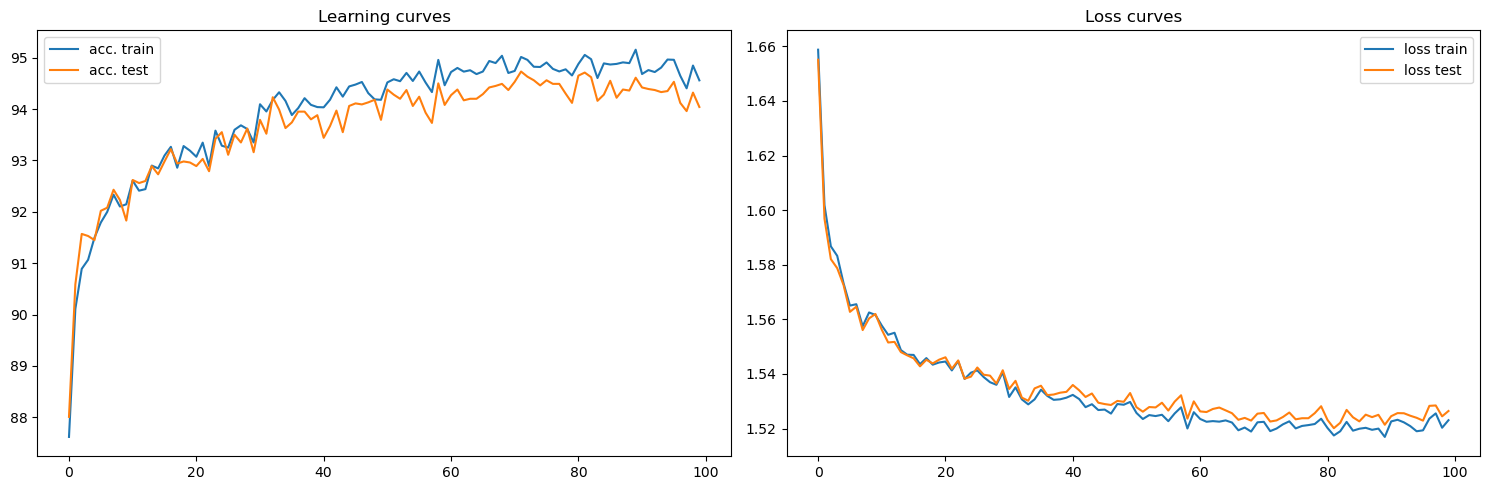

In [27]:
pbar = trange(100)

# epoch
for iteration in pbar:
    # permute
    perm = np.random.permutation(N)
    Xtrain = data.Xtrain[perm, :]
    Ytrain = data.Ytrain[perm, :]

    # batches
    for j in range(N // Nbatch):
        indsBatch = range(j * Nbatch, (j + 1) * Nbatch)
        X = Xtrain[indsBatch, :]
        Y = Ytrain[indsBatch, :]

        optim.zero_grad()

        Yhat = model(X)
        L, acc = loss_accuracy(loss, Yhat, Y)
        L.backward()

        optim.step()

    Yhat_train = model(data.Xtrain)
    Yhat_test = model(data.Xtest)
    Ltrain, acctrain = loss_accuracy(loss, Yhat_train, data.Ytrain)
    Ltest, acctest = loss_accuracy(loss, Yhat_test, data.Ytest)

    title = "Iter {}: Acc train {:.1f}% ({:.2f}), acc test {:.1f}% ({:.2f})".format(
        iteration, acctrain, Ltrain, acctest, Ltest
    )
    pbar.set_description(title)

    curves[0].append(acctrain)
    curves[1].append(acctest)
    curves[2].append(Ltrain.detach())
    curves[3].append(Ltest.detach())

fig = plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(curves[0], label="acc. train")
plt.plot(curves[1], label="acc. test")
plt.title("Learning curves")
plt.legend()
plt.subplot(122)
plt.plot(curves[2], label="loss train")
plt.plot(curves[3], label="loss test")
plt.title("Loss curves")
plt.legend()
plt.tight_layout()
plt.savefig("mnist_acc_loss.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Looking at the prediction

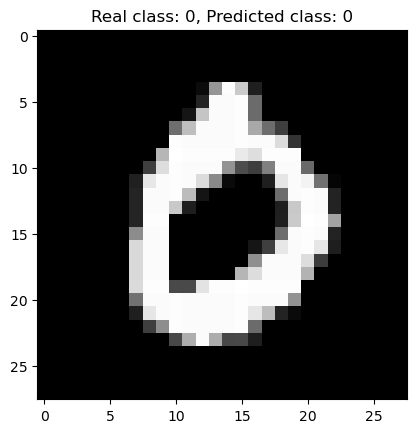

In [28]:
plt.imshow(data.Xtest[0].reshape((28, 28)), cmap="gray")
plt.title(f"Real class: {data.Ytest[0].argmax()}, Predicted class: {Yhat_test[0].argmax()}")
plt.show()

### Find misclassified data

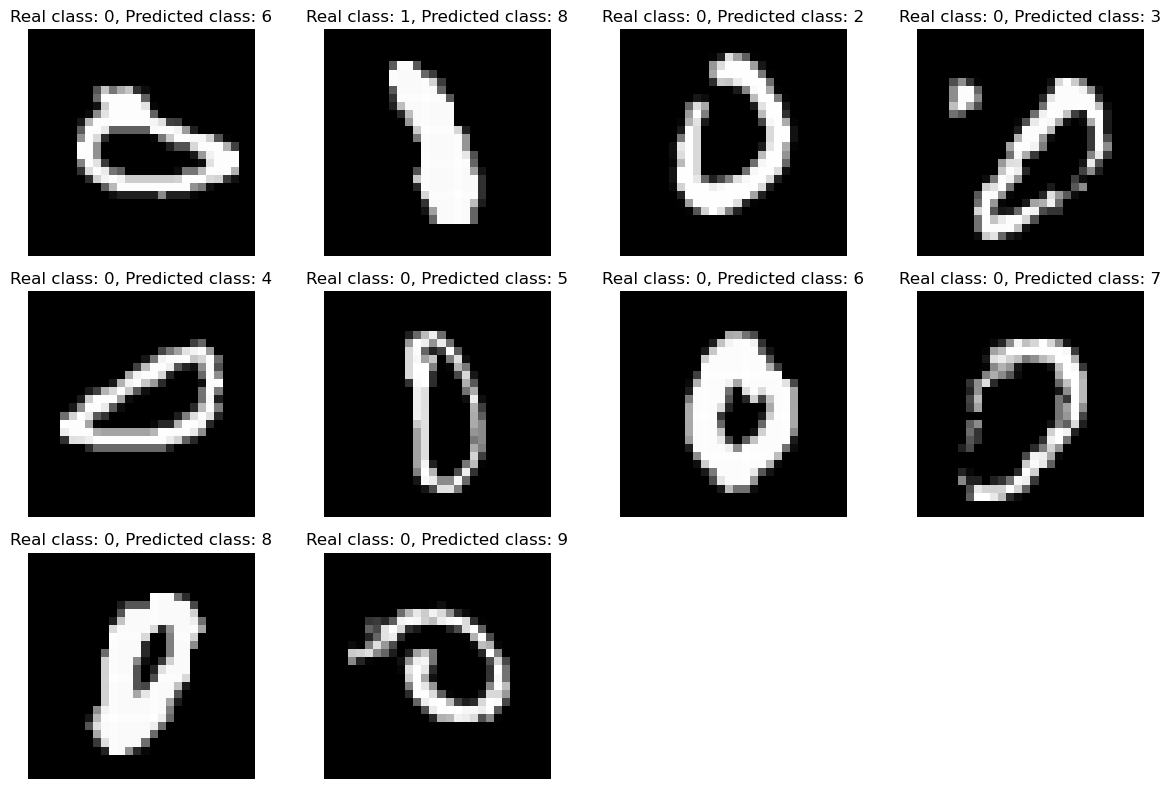

In [29]:
# Find misclassified data
mismatches = ((data.Ytest != Yhat_test.round()).float()).argmax(dim=0)

# Create subplots with a number of rows depending on the length of mismatches
n_mismatches = len(mismatches)
n_rows = min(3, n_mismatches)  # Maximum 3 rows for subplots
n_cols = (n_mismatches + n_rows - 1) // n_rows  # Calculate the number of columns

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12, 8))
axes = axes.ravel()
for i, ax in enumerate(axes):
    if i < n_mismatches:
        idx = mismatches[i]
        ax.imshow(data.Xtest[idx].reshape((28, 28)), cmap="gray")
        ax.set_title(f"Real class: {data.Ytest[idx].argmax()}, Predicted class: {Yhat_test[idx].argmax()}")
        ax.axis("off")
    else:
        fig.delaxes(ax)  # Remove any empty subplots

plt.tight_layout()
plt.show()

### Confusion Matrix

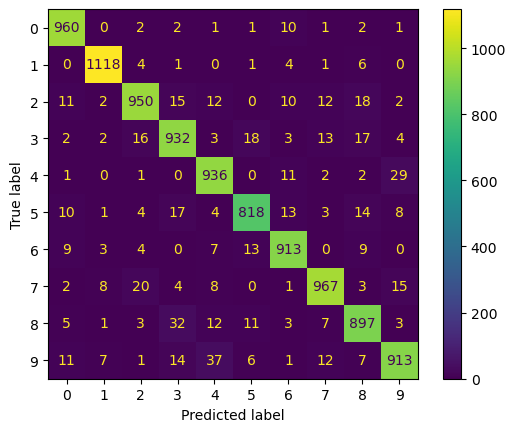

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(data.Ytest.argmax(dim=1), Yhat_test.detach().argmax(dim=1))

cm_display = ConfusionMatrixDisplay(cm).plot()
plt.savefig("mnist_cm.pdf", format="pdf", bbox_inches="tight")

# Part 6 : SVM

In [57]:
# data
data = CirclesData()
Xtrain = data.Xtrain.numpy()
Ytrain = data.Ytrain[:, 0].numpy()

Xgrid = data.Xgrid.numpy()

Xtest = data.Xtest.numpy()
Ytest = data.Ytest[:, 0].numpy()


def plot_svm_predictions(data, predictions):
    plt.figure(2)
    # plt.clf()
    plt.imshow(np.reshape(predictions, (40, 40)))
    plt.plot(
        data._Xtrain[data._Ytrain[:, 0] == 1, 0] * 10 + 20,
        data._Xtrain[data._Ytrain[:, 0] == 1, 1] * 10 + 20,
        "bo",
        label="Train",
    )
    plt.plot(
        data._Xtrain[data._Ytrain[:, 1] == 1, 0] * 10 + 20,
        data._Xtrain[data._Ytrain[:, 1] == 1, 1] * 10 + 20,
        "ro",
    )
    plt.plot(
        data._Xtest[data._Ytest[:, 0] == 1, 0] * 10 + 20,
        data._Xtest[data._Ytest[:, 0] == 1, 1] * 10 + 20,
        "b+",
        label="Test",
    )
    plt.plot(
        data._Xtest[data._Ytest[:, 1] == 1, 0] * 10 + 20,
        data._Xtest[data._Ytest[:, 1] == 1, 1] * 10 + 20,
        "r+",
    )
    plt.xlim(0, 39)
    plt.ylim(0, 39)
    plt.clim(0.3, 0.7)
    # plt.draw()
    # plt.pause(1e-3)

## Linear SVM

Linear SVM Accuracy: 53.00%


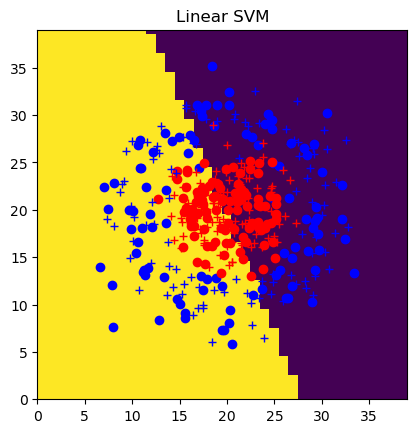

In [58]:
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score

# Train a Linear SVM
linear_svm = LinearSVC(dual="auto")
linear_svm.fit(Xtrain, Ytrain)

# Evaluate the Linear SVM
Ytest_pred_linear = linear_svm.predict(Xtest)
accuracy_linear = np.sum(Ytest == Ytest_pred_linear) / len(Ytest)
print(f"Linear SVM Accuracy: {100 * accuracy_linear:.2f}%")
Ygrid_pred = linear_svm.predict(Xgrid)
plot_svm_predictions(data, Ygrid_pred)
plt.title("Linear SVM")
plt.savefig("svm_linear.pdf", format="pdf", bbox_inches="tight")

A linear SVM doesn't work well with circular data because linear SVMs are designed to find a linear decision boundary that separates data into two classes. Circular data cannot be accurately separated by a single straight line, which is our case here.


## SVM with different kernels

Poly SVM Accuracy: 54.50%
Rbf SVM Accuracy: 94.00%
Sigmoid SVM Accuracy: 65.00%


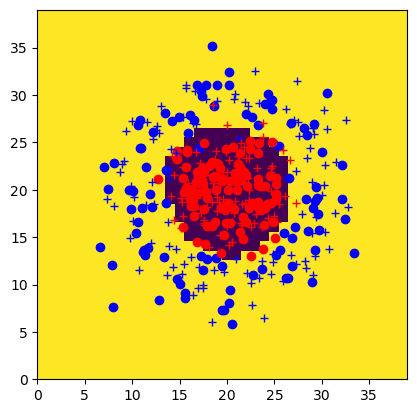

In [59]:
# Train SVM with different kernels
kernel_names = ["poly", "rbf", "sigmoid"]
svm = {}
accuracy = {}
best_kernel = None
best_accuracy = 0.0

for kernel in kernel_names:
    svm[kernel] = SVC(kernel=kernel, C=1.0)  # You can vary the value of C here
    svm[kernel].fit(Xtrain, Ytrain)

    Ytest_pred = svm[kernel].predict(Xtest)
    accuracy[kernel] = accuracy_score(Ytest, Ytest_pred)
    print(f"{kernel.capitalize()} SVM Accuracy: {100 * accuracy[kernel]:.2f}%")

    if accuracy[kernel] > best_accuracy:
        best_accuracy = accuracy[kernel]
        best_kernel = kernel

# Plot predictions of the best SVM model
best_svm = SVC(kernel=best_kernel, C=1.0)
best_svm.fit(Xtrain, Ytrain)
Ygrid_pred = best_svm.predict(Xgrid)
plot_svm_predictions(data, Ygrid_pred)

The Radial Basis Function (RBF) kernel is often the best choice compared to polynomial and sigmoid kernels for circular data because it can capture complex, nonlinear patterns more effectively, and it is better suited to model the circular decision boundaries typically found in such data. RBF kernels can flexibly adapt to various shapes and are more versatile in representing circular patterns, as shown here.


In [51]:
def plot_svm_predictions_subplot(ax, data, predictions, title):
    ax.imshow(np.reshape(predictions, (40, 40)))
    ax.plot(
        data._Xtrain[data._Ytrain[:, 0] == 1, 0] * 10 + 20,
        data._Xtrain[data._Ytrain[:, 0] == 1, 1] * 10 + 20,
        "bo",
        label="Train",
    )
    ax.plot(
        data._Xtrain[data._Ytrain[:, 1] == 1, 0] * 10 + 20,
        data._Xtrain[data._Ytrain[:, 1] == 1, 1] * 10 + 20,
        "ro",
    )
    ax.plot(
        data._Xtest[data._Ytest[:, 0] == 1, 0] * 10 + 20,
        data._Xtest[data._Ytest[:, 0] == 1, 1] * 10 + 20,
        "b+",
        label="Test",
    )
    ax.plot(
        data._Xtest[data._Ytest[:, 1] == 1, 0] * 10 + 20,
        data._Xtest[data._Ytest[:, 1] == 1, 1] * 10 + 20,
        "r+",
    )
    ax.set_xlim(0, 39)
    ax.set_ylim(0, 39)
    ax.set_title(title)

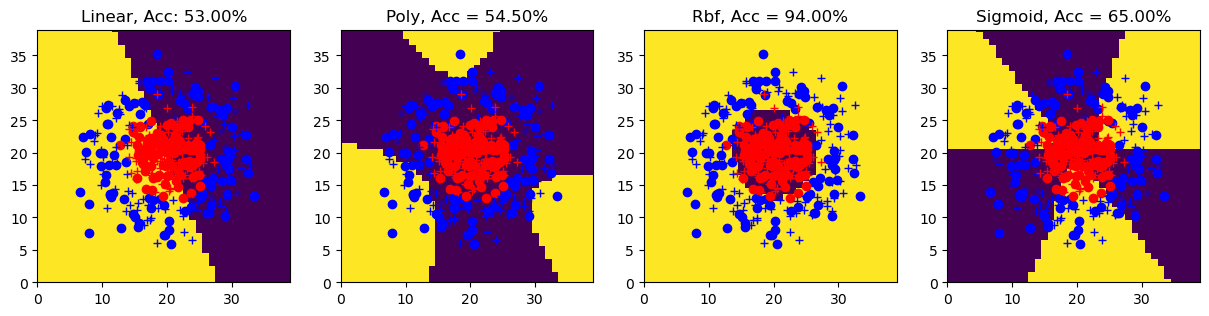

In [63]:
fig, ax = plt.subplots(1, 4, figsize=(15, 5))

title = f"Linear, Acc: {100 * accuracy_linear:.2f}%"
plot_svm_predictions_subplot(ax[0], data, linear_svm.predict(Xgrid), title)
for idx, kernel in enumerate(svm):
    title = f"{kernel.capitalize()}, Acc = {100 * accuracy[kernel]:.2f}%"
    plot_svm_predictions_subplot(ax[idx + 1], data, svm[kernel].predict(Xgrid), title)
plt.savefig("svm_comparison.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Influence of regularization parameter

Poly SVM Accuracy (C=1e-05): 50.00%
Poly SVM Accuracy (C=0.001): 50.00%
Poly SVM Accuracy (C=0.01): 50.00%
Poly SVM Accuracy (C=1): 54.50%
Poly SVM Accuracy (C=10): 54.50%
Poly SVM Accuracy (C=100): 54.50%
Rbf SVM Accuracy (C=1e-05): 95.00%
Rbf SVM Accuracy (C=0.001): 95.00%
Rbf SVM Accuracy (C=0.01): 95.00%
Rbf SVM Accuracy (C=1): 94.00%
Rbf SVM Accuracy (C=10): 93.50%
Rbf SVM Accuracy (C=100): 93.00%
Sigmoid SVM Accuracy (C=1e-05): 54.00%
Sigmoid SVM Accuracy (C=0.001): 54.00%
Sigmoid SVM Accuracy (C=0.01): 54.00%
Sigmoid SVM Accuracy (C=1): 65.00%
Sigmoid SVM Accuracy (C=10): 50.50%
Sigmoid SVM Accuracy (C=100): 49.00%


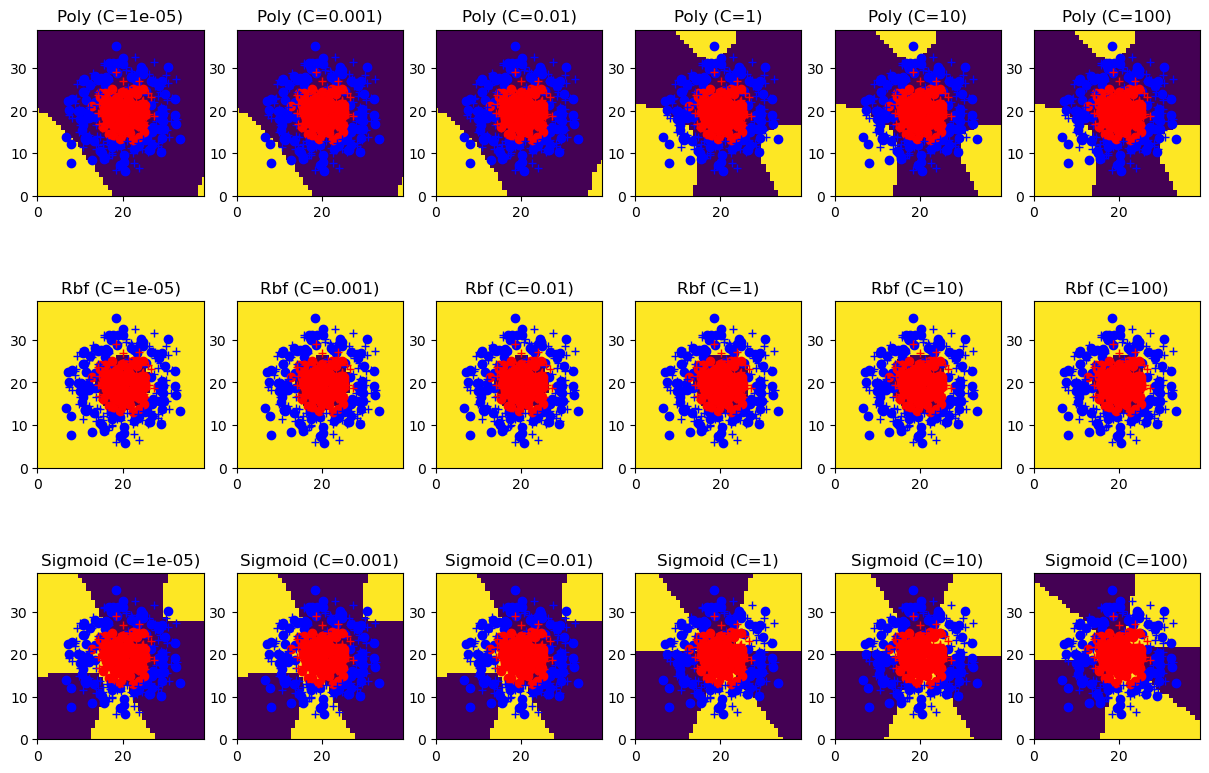

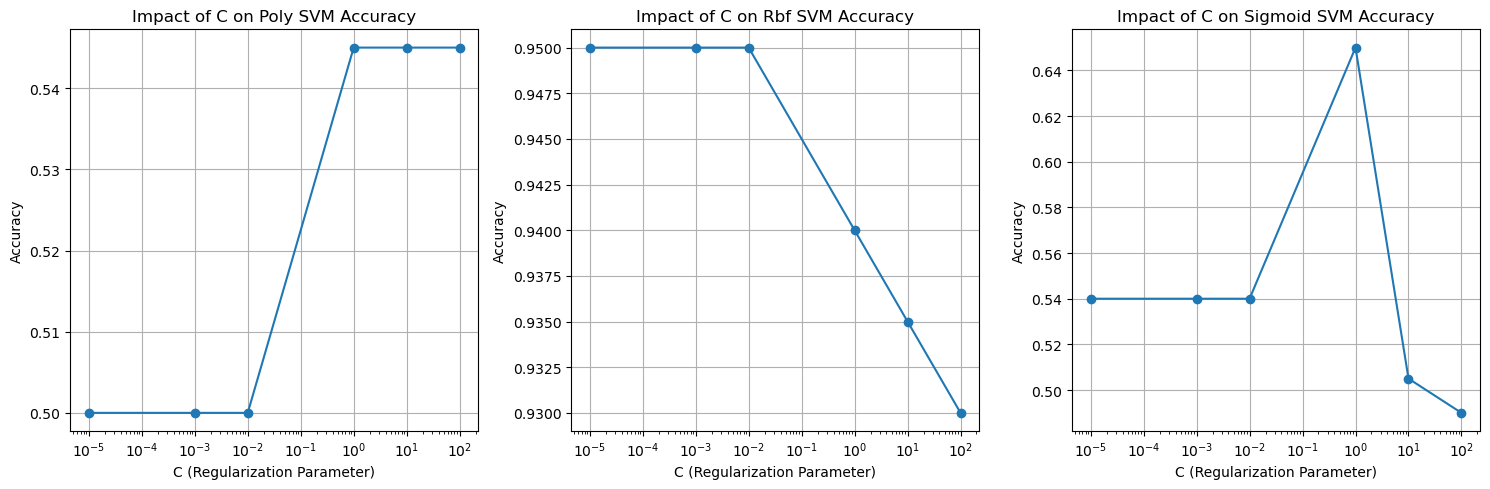

In [55]:
# Train an SVM with a different regularization parameter C
C_values = [1e-5, 1e-3, 0.01, 1, 10, 100]
kernel_names = ["poly", "rbf", "sigmoid"]
n = len(C_values)
accuracies = []

# Create subplots for each kernel
fig, axes = plt.subplots(nrows=len(kernel_names), ncols=n, figsize=(15, 10))

for i, kernel in enumerate(kernel_names):
    predictions = []
    for j, C in enumerate(C_values):
        svm = SVC(kernel=kernel, C=C)
        svm.fit(Xtrain, Ytrain)
        Ytest_pred = svm.predict(Xtest)
        Ygrid_pred = svm.predict(Xgrid)
        predictions.append(Ygrid_pred)
        accuracy = accuracy_score(Ytest, Ytest_pred)
        accuracies.append(accuracy)
        print(f"{kernel.capitalize()} SVM Accuracy (C={C}): {100 * accuracy:.2f}%")
        title = f"{kernel.capitalize()} (C={C})"
        plot_svm_predictions_subplot(axes[i, j], data, predictions[j], title)
plt.savefig("svm_regularization_grid.pdf", format="pdf", bbox_inches="tight")

# Plot the impact of C on accuracy for each kernel
plt.figure(figsize=(15, 5))
for i, kernel in enumerate(kernel_names):
    plt.subplot(1, len(kernel_names), i + 1)
    plt.plot(C_values, accuracies[i * n : (i + 1) * n], marker="o")
    plt.xscale("log")
    plt.xlabel("C (Regularization Parameter)")
    plt.ylabel("Accuracy")
    plt.title(f"Impact of C on {kernel.capitalize()} SVM Accuracy")
    plt.grid(True)

plt.tight_layout()
plt.savefig("svm_regularization_acc.pdf", format="pdf", bbox_inches="tight")
plt.show()

The parameter $C$ in SVMs controls the trade-off between maximizing the margin and minimizing the classification error on the training data.

When $C$ is large, the SVM aims to minimize the classification error on the training data, which results in a smaller margin, meaning that the decision boundary can be more flexible and may even fit noisy data points. This can lead to overfitting.

When $C$ is small, the SVM prioritizes maximizing the margin, even if it means allowing some training points to be misclassified. It results in a larger margin, which often leads to a simpler decision boundary. It encourages the SVM to find a more robust decision boundary that generalizes better to unseen data.
